Words in index: 22101

 Evaluation of model with ALL layers fine-tuned:

 Evaluation of model with LAST layer fine-tuned:

 Evaluation of model trained from scratch:
Found women stupid


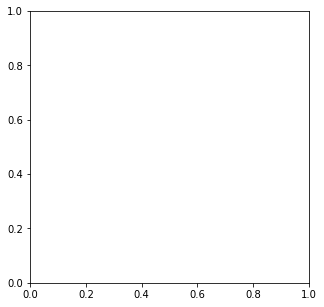

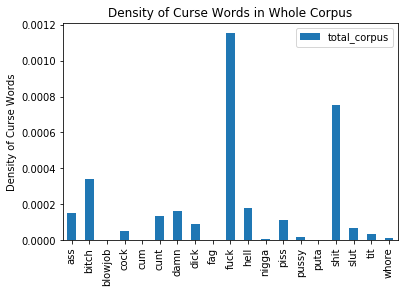

/home/tcake/coding_projects/python/opt_out/find-out/src/evaluation/hatespeech/evaluation_translearn_hatespeech.py:110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['curse_words'] = df['text'].apply(lambda tweet: density_of_curse_words_in_sentence(tweet))


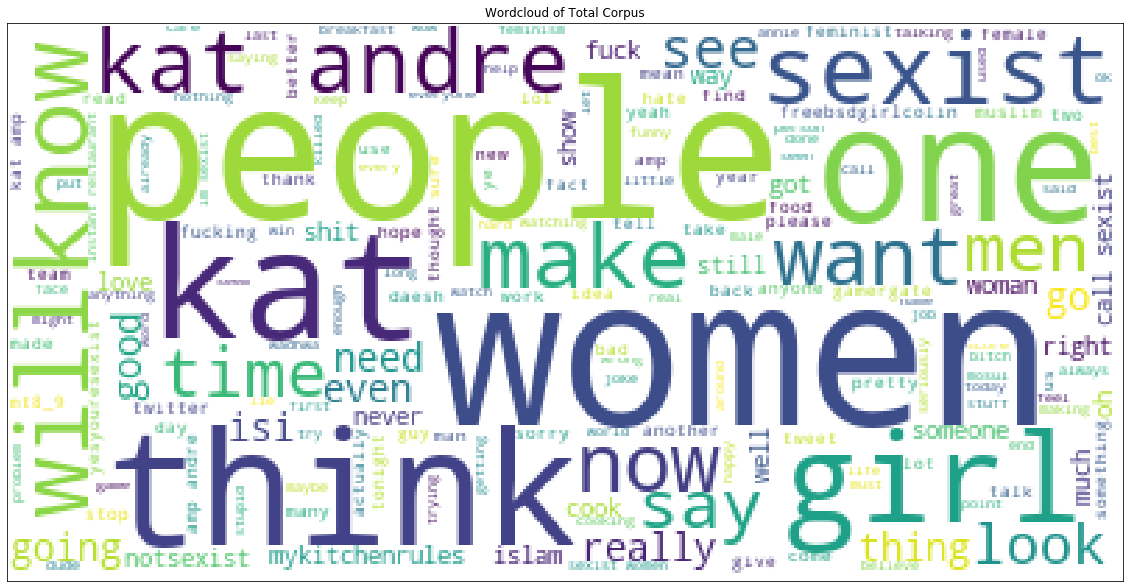

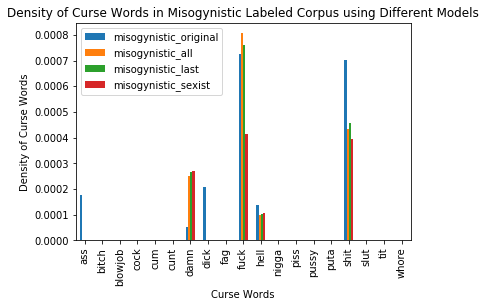

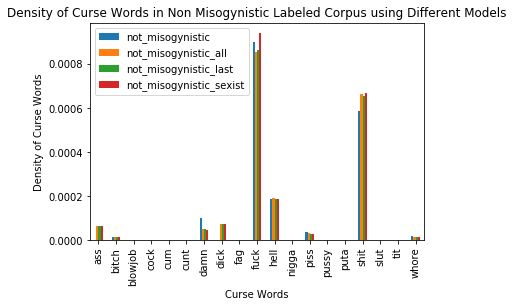

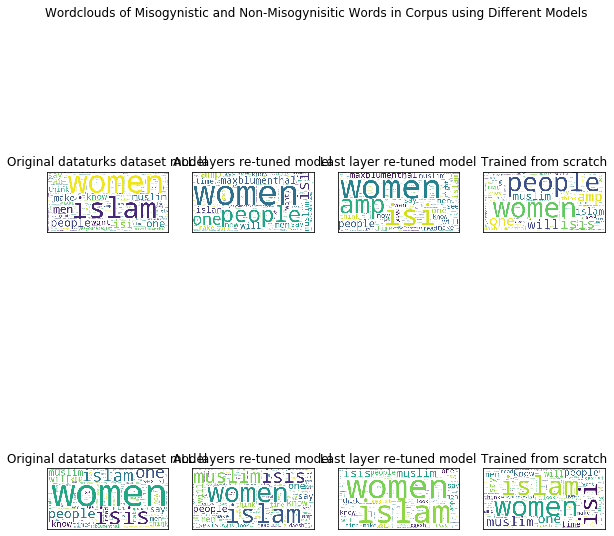

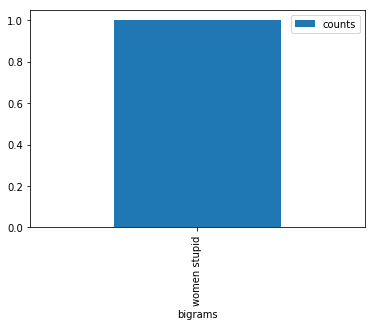

AttributeError: 'AxesSubplot' object has no attribute 'set_titles'

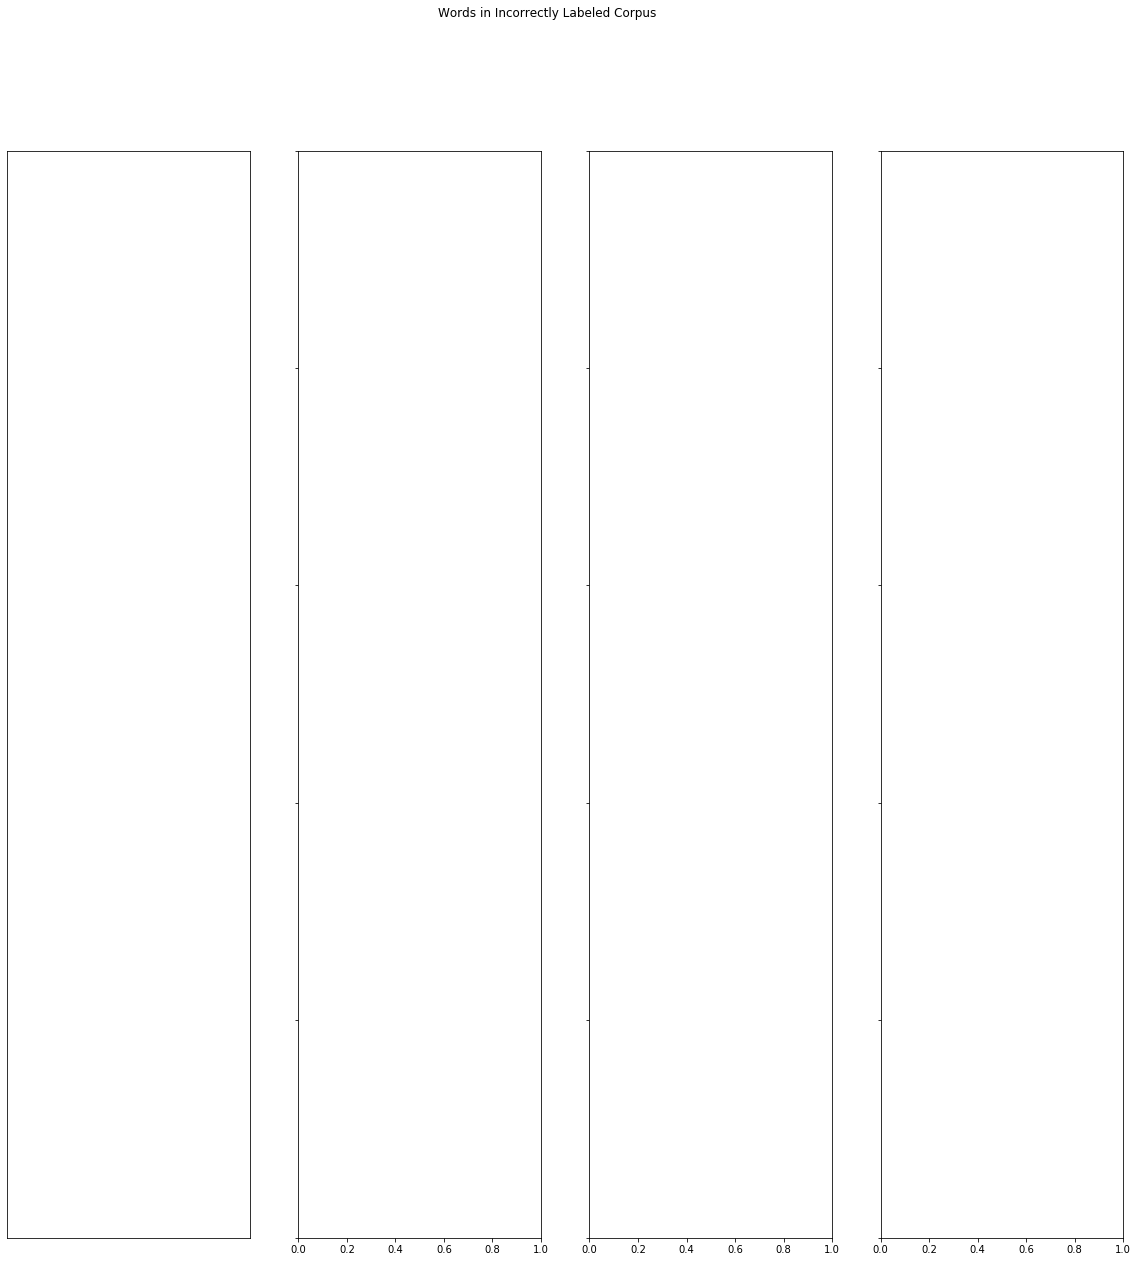

In [2]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from src.data.preprocess.dataturks.preprocess_translearn_hatespeech import create_NN_sets
from src.evaluation.hatespeech.evaluation_translearn_hatespeech import evaluate_best_model, get_predictions, \
    draw_wordcloud, generate_ngrams, contains_bigram, density_of_curse_words_in_total_corpus, count_pejorative_bigrams
from src.models.hatespeech.model_translearn_hatespeech import fine_tune_model, create_model

np.random.seed(42)
vocab_size = 10000

path_to_target_data = "../../data/external/hatespeech/clean_sexism_dataset.csv"
path_to_original_model = "../../models/example_dataturks.h5"
path_to_fine_tuned_model = "../../models/fine_tuned.h5"
path_to_fine_tuned_model_last = "../../models/fine_tuned_last_layer.h5"
path_to_sexist_model = "../../models/zeerak_model.h5"

datasets = create_NN_sets(path_to_target_data, vocab_size)
# fine_tune_model(path_to_original_model, path_to_fine_tuned_model, datasets)
print("\n Evaluation of model with ALL layers fine-tuned:")
# evaluate_best_model(path_to_fine_tuned_model, datasets[4], datasets[5], datasets[6], 10000)
# fine_tune_model(path_to_original_model, path_to_fine_tuned_model2, datasets)
print("\n Evaluation of model with LAST layer fine-tuned:")
# evaluate_best_model(path_to_fine_tuned_model_last, datasets[4], datasets[5], datasets[6], 10000)
# train_model(path_to_sexist_model, datasets, vocab_size)
print("\n Evaluation of model trained from scratch:")
# evaluate_best_model(path_to_sexist_model, datasets[4], datasets[5], datasets[6], 10000)

def returns_predictions(path_to_model, differences=False):
    """ Returns the dataframe with only the rows where the labeling is different
    Args:
        path_to_model (str) : the path the to model to be studied.
    Returns:
        df (pandas df) : the dataframe containing rows where the labeling was different.
    """
    data = pd.read_csv(path_to_target_data)
    best_model = create_model(datasets[6], vocab_size)
    best_model.load_weights(path_to_model)
    predictions = get_predictions(best_model, datasets[4])
    df_pred = pd.DataFrame({"prediction": predictions})
    df_test = data.loc[datasets[5].index, :].reset_index()
    df = pd.concat([df_test, df_pred], axis=1)
    if differences == False:
        return df
    else:
        return df.loc[df.loc[:, "label"] != df.loc[:, "prediction"]]

def returns_misogynistic_predictions(df, misogynistic=True):
    """Returns the predicted or not misogynistic data."""
    if misogynistic == True:
        return df.loc[df.loc[:, "prediction"] == 1]
    else:
        return df.loc[df.loc[:, "prediction"] == 0]


### TOTAL CORPUS ANALYSIS

## Density of CW
total_corpus = pd.read_csv(path_to_target_data)
fig, ax = plt.subplots(figsize=(5, 5))
ax = density_of_curse_words_in_total_corpus(total_corpus, "total_corpus").plot.bar()
ax.set_ylabel('Density of Curse Words')
ax.set_title('Curse Words')
ax.set_title('Density of Curse Words in Whole Corpus', fontsize=12)
plt.savefig("curse_words_total_corpus.png")
plt.show()

## Word Cloud
fig, ax = plt.subplots(figsize=(20, 20))
ax.imshow(draw_wordcloud(total_corpus['text']))
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.set_title('Wordcloud of Total Corpus', fontsize=12)
plt.savefig("total_corpus.png")


### EDA of PREDICTIONS
df_original = returns_predictions(path_to_original_model)
df_all = returns_predictions(path_to_fine_tuned_model)
df_last = returns_predictions(path_to_fine_tuned_model_last)
df_sexist = returns_predictions(path_to_sexist_model)

## Density of CW
misogynistic_original = density_of_curse_words_in_total_corpus(returns_misogynistic_predictions(df_original),
                                                               "misogynistic_original")
misogynistic_all = density_of_curse_words_in_total_corpus(returns_misogynistic_predictions(df_all), "misogynistic_all")
misogynistic_last = density_of_curse_words_in_total_corpus(returns_misogynistic_predictions(df_last),
                                                           "misogynistic_last")
misogynistic_sexist = density_of_curse_words_in_total_corpus(returns_misogynistic_predictions(df_sexist),
                                                             "misogynistic_sexist")
not_misogynistic_original = density_of_curse_words_in_total_corpus(
    returns_misogynistic_predictions(df_original, misogynistic=False), "not_misogynistic")
not_misogynistic_all = density_of_curse_words_in_total_corpus(
    returns_misogynistic_predictions(df_all, misogynistic=False), "not_misogynistic_all")
not_misogynistic_last = density_of_curse_words_in_total_corpus(
    returns_misogynistic_predictions(df_last, misogynistic=False), "not_misogynistic_last")
not_misogynistic_sexist = density_of_curse_words_in_total_corpus(
    returns_misogynistic_predictions(df_sexist, misogynistic=False), "not_misogynistic_sexist")

pd.concat([misogynistic_original, misogynistic_all, misogynistic_last, misogynistic_sexist], axis=1).plot.bar()
plt.title("Density of Curse Words in Misogynistic Labeled Corpus using Different Models")
plt.ylabel("Density of Curse Words")
plt.xlabel("Curse Words")
plt.savefig("misogynistic_cursewords_models_corpus.png")
plt.show()

pd.concat([not_misogynistic_original, not_misogynistic_all, not_misogynistic_last, not_misogynistic_sexist], axis=1).plot.bar()
plt.title("Density of Curse Words in Non Misogynistic Labeled Corpus using Different Models")
plt.ylabel("Density of Curse Words")
plt.xlabel("Curse Words")
plt.savefig("not_misogynistic_cursewords_models_corpus.png")
plt.show()


## Word Clouds
fig, ax = plt.subplots(2, 4, sharey=True, figsize=(10, 10))
fig.suptitle("Wordclouds of Misogynistic and Non-Misogynisitic Words in Corpus using Different Models")
titles = ["Original dataturks dataset model", "ALL layers re-tuned model", "Last layer re-tuned model",
          "Trained from scratch"]
dfs = [df_original, df_all, df_last, df_sexist]


def plot_wordclouds(data, row, column, title, misogynistic=True):
    if misogynistic == True:
        ax[row, column].imshow(draw_wordcloud(returns_misogynistic_predictions(data)['text']))
        ax[row, column].set_title(title)
        ax[row, column].xaxis.set_visible(False)
        ax[row, column].yaxis.set_visible(False)
        return ax
    else:
        ax[row, column].imshow(draw_wordcloud(returns_misogynistic_predictions(data, misogynistic=False)['text']))
        ax[row, column].set_title(title)
        ax[row, column].xaxis.set_visible(False)
        ax[row, column].yaxis.set_visible(False)
        return ax
for row in range(0, 2):
    for column in range(0, 4):
        if row == 0:
            plot_wordclouds(dfs[column], row, column, titles[column])
        else:
            plot_wordclouds(dfs[column], row, column, titles[column], misogynistic=False)
plt.savefig("labelled_text.png")
plt.show()

## generate_ngrams
bigrams = df_original['text'].apply(lambda tweet: generate_ngrams(tweet, 2))
df_bigrams = pd.DataFrame(bigram for bigram in bigrams)
df_bigrams = df_bigrams.fillna("no bigram")

ADJECTIVE = r"""(dumb|stupid|unmarried|barren|sexy|trampy)"""
FEMALE = r"""(woman|women|girl|girls|blondes|blonde|slut|sluts|bitch|bitches|whore|whores)"""

all_bigrams = []
for i in range(0, len(df_bigrams.columns)):
    all_bigrams.append(df_bigrams[i].apply(lambda bigram: contains_bigram(bigram, ADJECTIVE, FEMALE)))

counts = count_pejorative_bigrams(all_bigrams)
df_bigrams_counts = pd.DataFrame(counts, columns=["bigrams", "counts"]).groupby("bigrams").count().plot.bar()
plt.show()

### ERROR ANALYSIS - WHAT WE GOT WRONG
incorrect_df_original = returns_predictions(path_to_original_model, differences=True)
incorrect_df_all = returns_predictions(path_to_fine_tuned_model, differences=True)
incorrect_df_last = returns_predictions(path_to_fine_tuned_model_last, differences=True)
incorrect_df_sexist = returns_predictions(path_to_sexist_model, differences=True)

## Word Cloud
fig, ax = plt.subplots(1, 4, sharey=True, figsize=(20, 20))
fig.suptitle("Words in Incorrectly Labeled Corpus")
for i in range(0, 4):
    ax[i].xaxis.set_visible(False)
    ax[i].yaxis.set_visible(False)
    ax[i].set_title(titles[i])
ax[0].imshow(draw_wordcloud(incorrect_df_original['text']))
ax[1].imshow(draw_wordcloud(incorrect_df_all['text']))
ax[2].imshow(draw_wordcloud(incorrect_df_last['text']))
ax[3].imshow(draw_wordcloud(incorrect_df_sexist['text']))
plt.plot()
plt.savefig("words_in_incorretly_labelled_text.png")
plt.show()